## Bank Customer Churn Prediction - EDA

This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

It consists of 10,000 records with demographic and bank history information from customers from three countries, France, Germany and Spain,

## Importing Libraries

In [93]:
import pandas as pd
import numpy as np
# Matplotlib for visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
# Seaborn for easier visualization
import seaborn as sns
# display plots in the notebook
%matplotlib inline
import os
sns.set_style('darkgrid')
# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer, make_column_transformer
#from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#Function for creating model pipelines -imblance
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-Sampling using SMOTE
from imblearn.over_sampling import SMOTE

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree

import xgboost as xgb

#Joblib is a set of Python tools designed for lightweight pipelining, providing fast disk-caching of functions (memoization) and simple parallel computing
import joblib
from tensorflow.keras.models import load_model

## Load Dataset

In [94]:
url = "/content/Churn_Modelling.csv"
df = pd.read_csv(url)
print(f"Dataset dimensions: {df.shape}")
df.head()

Dataset dimensions: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [96]:
df.CustomerId.nunique()

10000

In [97]:
df.duplicated().sum()

np.int64(0)

Unused Features

To make dataframe easily readable we will drop features not needed for machine learning:

* RowNumber

* CustomerId

* Surname

In [98]:
df.drop(['RowNumber','CustomerId','Surname'],axis = 1, inplace = True)
print(f"DatasetFrame dimensions: {df.shape}")
df.head()

DatasetFrame dimensions: (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Distributions of Numeric Features

#### Plotting Histogram grid

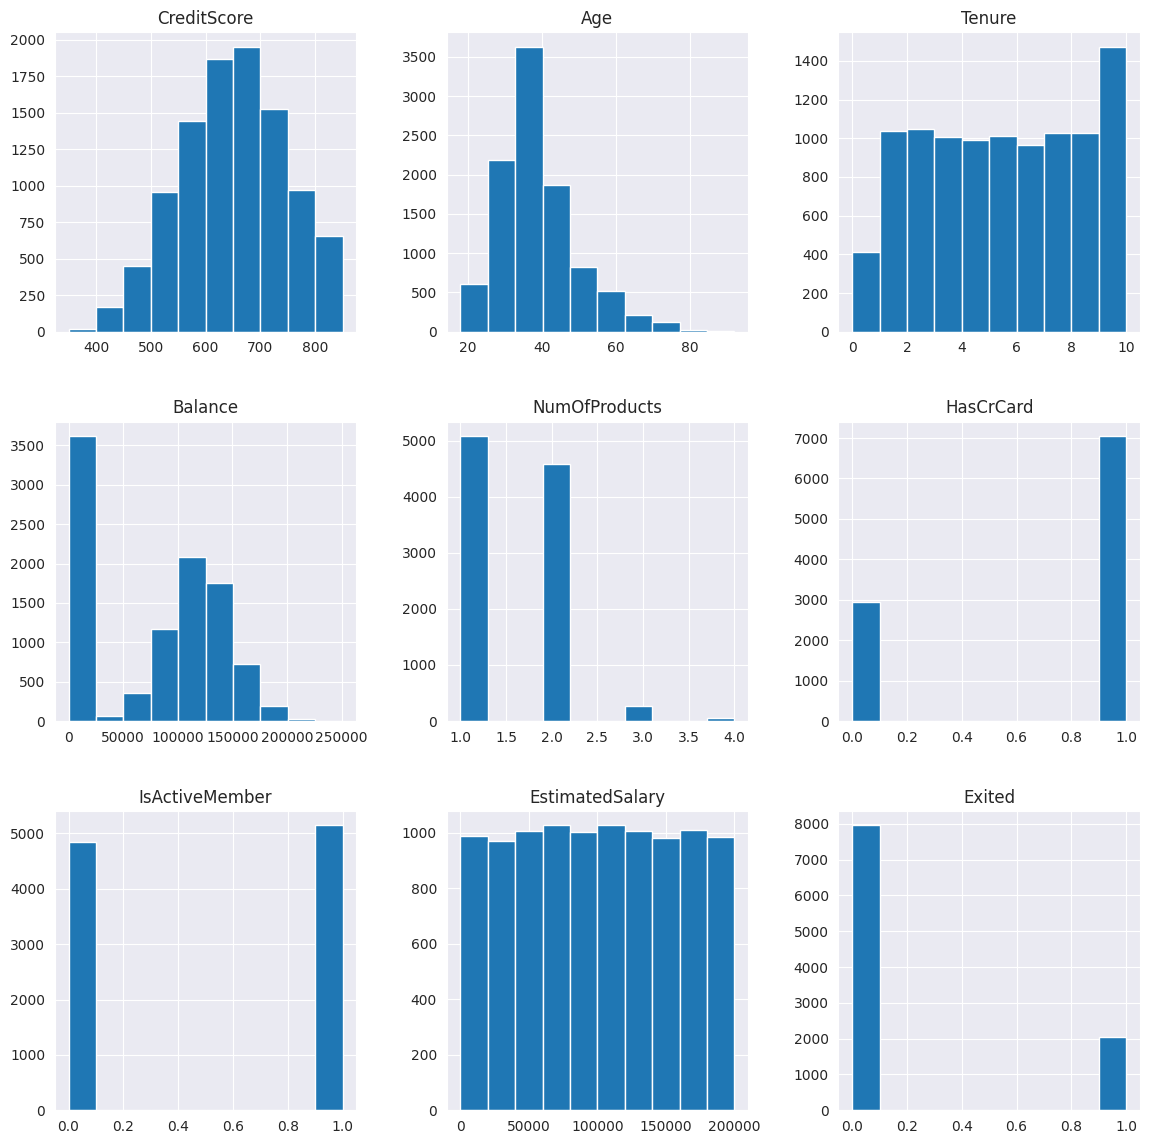

In [99]:
df.hist(figsize = (14,14))
plt.show()

In [100]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


From the summary statistics and the histograms we can conclude that all features look OK. We do not see any extreme values for any feature.

In [101]:
# Summarize categorical features
df.describe(include=['object'])

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


This shows us the number of unique classes for each feature. For example, there are more males (5457) than females. And France is most common of 3 geographies in our dataframe. There are no sparse classes.

Let's visualize this information.

Counter({'Female': 4543, 'Male': 5457})

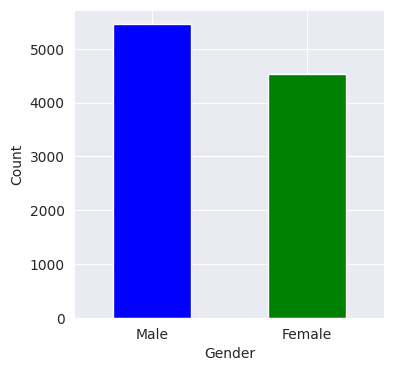

In [102]:
# Bar plot for "Gender"
plt.figure(figsize=(4,4))
df['Gender'].value_counts().plot.bar(color = ['b','g'])
plt.ylabel('Count')
plt.xlabel('Gender')
plt.xticks(rotation = 0)

# Display count of each class
Counter(df.Gender)

In our data sample there are more males than females.

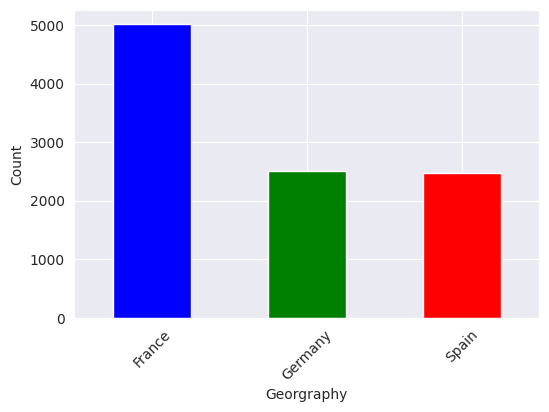

Counter({'France': 5014, 'Spain': 2477, 'Germany': 2509})

In [103]:
# Bar plot for "Geography"
plt.figure(figsize=(6,4))
df['Geography'].value_counts().plot.bar(color = ['b','g','r'])
plt.ylabel('Count')
plt.xlabel('Georgraphy')
plt.xticks(rotation = 45)
plt.show()

#Display the count of each classes
Counter(df.Geography)

Majority of customers are from France, about 50%, and from Germany and Spain around 25% each.

In [104]:
# Segment "Exited" by gender and display the frequency and percentage within each class
grouped  = df.groupby('Gender')['Exited'].agg(Count = 'value_counts')
grouped

Count
Gender Exited       
Female 0        3404
       1        1139
Male   0        4559
       1         898

In [105]:
# Reorganize dataframe for plotting count
dfgc = grouped
dfgc = dfgc.pivot_table(values = 'Count',index = 'Gender',columns=['Exited'])
dfgc

Exited,0,1
Gender,,
Female,3404.0,1139.0
Male,4559.0,898.0


In [106]:
# Calculate percentage within each class
dfgp= grouped.groupby(level=[0]).apply(lambda g: round(g * 100 / g.sum(),2))
dfgp.rename(columns = {'Count': 'Percentage'},inplace = True)
dfgp

Percentage
Gender Gender Exited            
Female Female 0            74.93
              1            25.07
Male   Male   0            83.54
              1            16.46

In [107]:
# Reorganize dataframe for plotting percentage
dfgp = dfgp.pivot_table(values='Percentage',index='Gender',columns=['Exited'])
dfgp

Exited,0,1
Gender,,
Female,74.93,25.07
Male,83.54,16.46


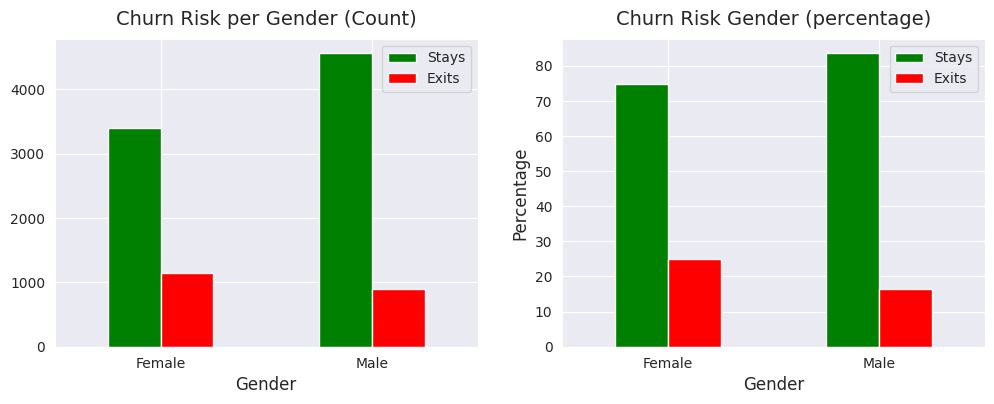

In [108]:
# Churn distribution by gender, count + percentage
labels = ['Stays','Exits']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

dfgc.plot(kind='bar',
          color=['g','r'],
          rot=0,
          ax = ax1)
ax1.legend(labels)
ax1.set_title('Churn Risk per Gender (Count)',fontsize = 14,pad=10)
ax1.set_xlabel('Gender',size = 12)

dfgp.plot(kind='bar',
          color=['g','r'],
          rot=0,
          ax=ax2)

ax2.legend(labels)
ax2.set_title('Churn Risk Gender (percentage)',fontsize = 14,pad=10)
ax2.set_ylabel('Percentage',size=12)
ax2.set_xlabel('Gender',size=12)
plt.show()

In percentage females are more likely to leave the bank; 25% comparing to males, 16%

In [109]:
# Segment "Exited" by geography and display the frequency and percentage within each class
grouped = df.groupby('Geography')['Exited'].agg(Count='value_counts')
grouped

Count
Geography Exited       
France    0        4204
          1         810
Germany   0        1695
          1         814
Spain     0        2064
          1         413

In [110]:
# Reorganize dataframe for plotting count
dfgeoc = grouped
dfgeoc = dfgeoc.pivot_table(values='Count',index='Geography',columns=['Exited'])
dfgeoc

Exited,0,1
Geography,,
France,4204.0,810.0
Germany,1695.0,814.0
Spain,2064.0,413.0


In [111]:
# Calculate percentage within each class
dfgeop = grouped.groupby(level=[0]).apply(lambda g: round(g * 100 / g.sum(),2))
dfgeop.rename(columns={'Count':'Percentage'},inplace = True)
dfgeop

Percentage
Geography Geography Exited            
France    France    0            83.85
                    1            16.15
Germany   Germany   0            67.56
                    1            32.44
Spain     Spain     0            83.33
                    1            16.67

In [112]:
# Reorganize dataframe for plotting percentage
dfgeop = dfgeop.pivot_table(values = 'Percentage',index = 'Geography',columns=['Exited'])
dfgeop

Exited,0,1
Geography,,
France,83.85,16.15
Germany,67.56,32.44
Spain,83.33,16.67


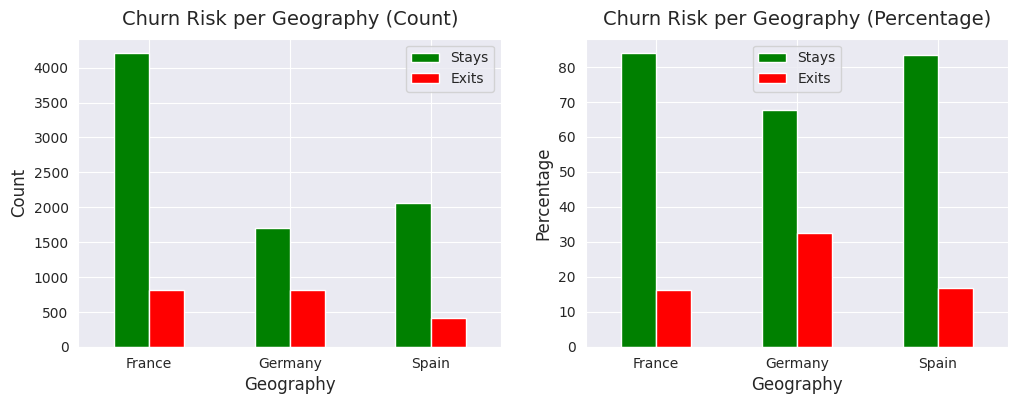

In [113]:
# Churn distribution by geography, count + percentage
labesl = ['Stays','Exits']

fig,(ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
dfgeoc.plot(kind='bar',
            color=['g','r'],
            rot=0,
            ax=ax1)
ax1.legend(labels)
ax1.set_title('Churn Risk per Geography (Count)',fontsize=14,pad=10)
ax1.set_ylabel('Count',size=12)
ax1.set_xlabel('Geography',size=12)

dfgeop.plot(kind='bar',
            color=['g','r'],
            rot=0,
            ax=ax2)
ax2.legend(labels)
ax2.set_title("Churn Risk per Geography (Percentage)",fontsize=14,pad=10)
ax2.set_ylabel('Percentage',size=12)
ax2.set_xlabel('Geography',size=12)
plt.show()

The smallest number of customers are from Germany but it looks that they are most likely to leave the bank. Almost one third of German customers in our sample left the bank.

### Correlations

In [114]:
# Calculate correlations between numeric features
correlations = df.corr(numeric_only=True)

#sort features in order of their correlation with "Exited"
sort_corr_cols = correlations.Exited.sort_values(ascending=False).keys()
sort_corr = correlations.loc[sort_corr_cols,sort_corr_cols]
sort_corr

,Exited,Age,Balance,EstimatedSalary,HasCrCard,Tenure,CreditScore,NumOfProducts,IsActiveMember
Exited,1.000000,0.285323,0.118533,0.012097,-0.007138,-0.014001,-0.027094,-0.047820,-0.156128
Age,0.285323,1.000000,0.028308,-0.007201,-0.011721,-0.009997,-0.003965,-0.030680,0.085472
Balance,0.118533,0.028308,1.000000,0.012797,-0.014858,-0.012254,0.006268,-0.304180,-0.010084
EstimatedSalary,0.012097,-0.007201,0.012797,1.000000,-0.009933,0.007784,-0.001384,0.014204,-0.011421
HasCrCard,-0.007138,-0.011721,-0.014858,-0.009933,1.000000,0.022583,-0.005458,0.003183,-0.011866
Tenure,-0.014001,-0.009997,-0.012254,0.007784,0.022583,1.000000,0.000842,0.013444,-0.028362
CreditScore,-0.027094,-0.003965,0.006268,-0.001384,-0.005458,0.000842,1.000000,0.012238,0.025651
NumOfProducts,-0.047820,-0.030680,-0.304180,0.014204,0.003183,0.013444,0.012238,1.000000,0.009612
IsActiveMember,-0.156128,0.085472,-0.010084,-0.011421,-0.011866,-0.028362,0.025651,0.009612,1.000000


Let's use Seaborn's .heatmap() function to visualize the correlation grid.

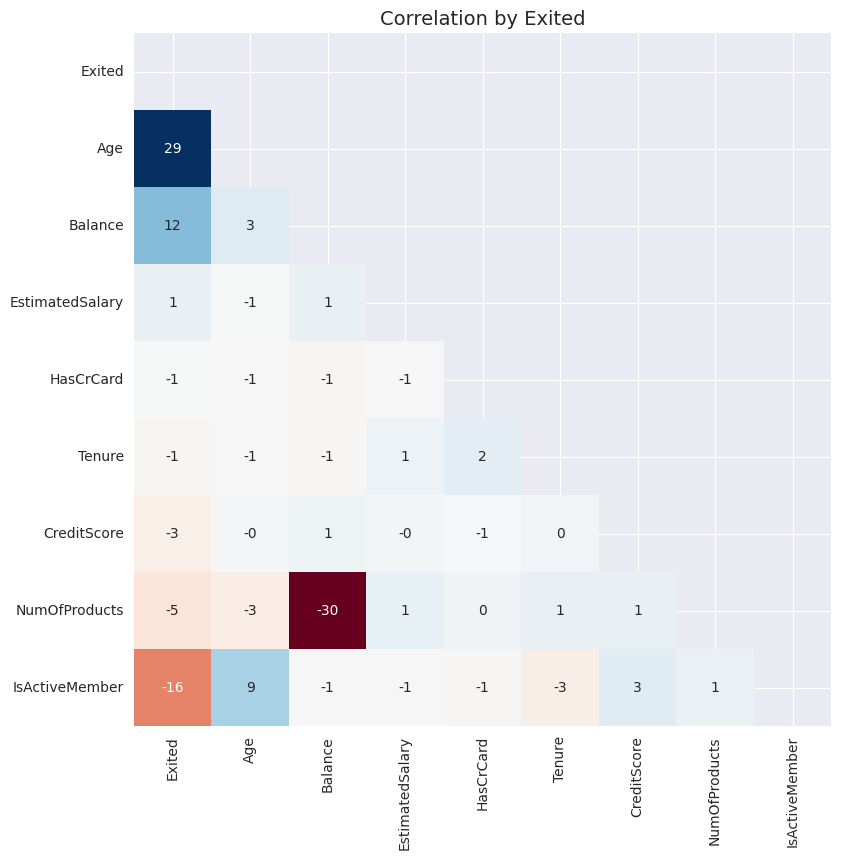

In [115]:
# Generate a mask for the upper triangle
corr_mask = np.zeros_like(correlations)
corr_mask[np.triu_indices_from(corr_mask)] = 1

# Make the figsize 9x9
plt.figure(figsize=(9,9))

# Plot heatmap of annotated correlations; change background to white
##with sns.axes_style('white'):
sns.heatmap(sort_corr*100,
            cmap='RdBu',
            annot=True,
            fmt='.0f',
            mask=corr_mask,
            cbar=False)

plt.title("Correlation by Exited", fontsize=14)
plt.yticks(rotation=0)
plt.show()

Very weak correlations in general. Only weak positive correlation with age, very weak positive correlation with balance, and very weak negative correlations with number of products and membership.

## Pairplot

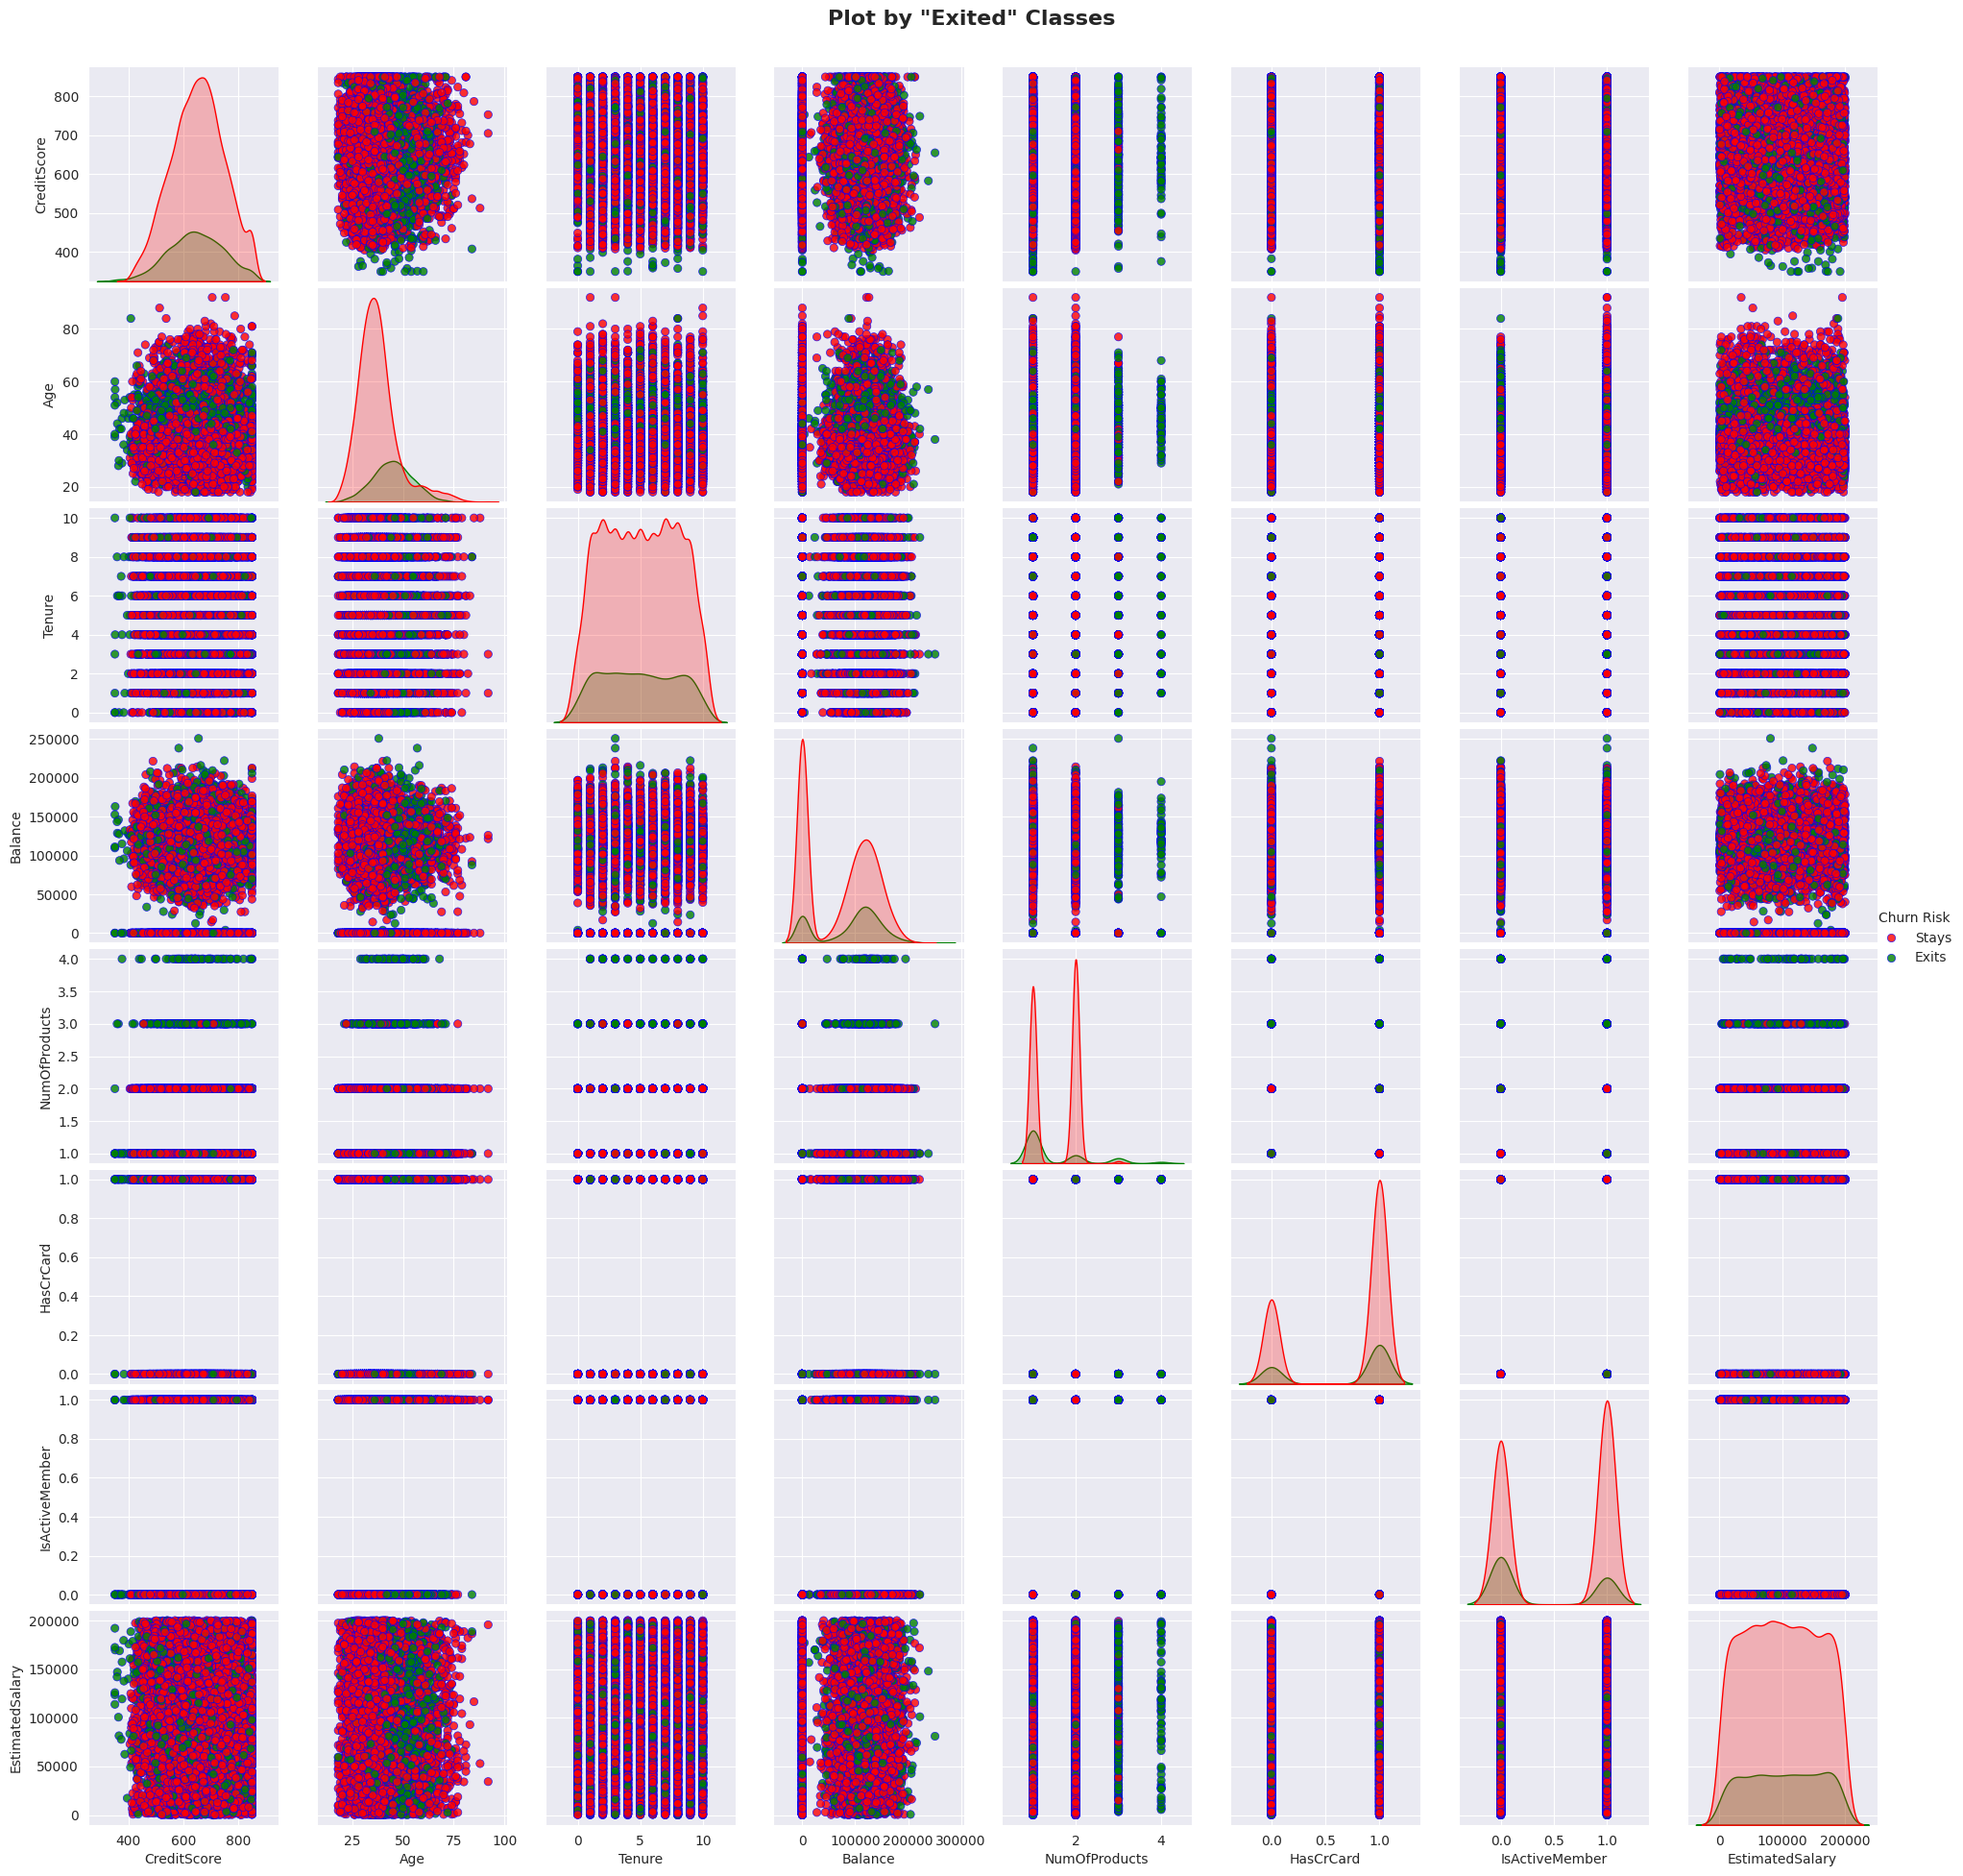

In [116]:
# Plot Seaborn's pairplot
g = sns.pairplot(df,hue='Exited',
                 palette={1 : 'green',
                          0 : 'red'},
                 plot_kws={'alpha' : 0.8, 'edgecolor' : 'b', 'linewidth' : 0.5})

fig = g.fig
fig.subplots_adjust(top=0.95,wspace=0.2)
fig.suptitle('Plot by "Exited" Classes',
             fontsize=16,
             fontweight='bold')

# Update the legend
new_title = 'Churn Risk'
g._legend.set_title(new_title)

# replace labels
new_labels = ['Stays','Exits']
for t, l in zip(g._legend.texts,new_labels): t.set_text(l)

plt.show()

The density plots on the diagonal make it easier to compare these distributions. We can notice that only few features have slightly different distributions. For example, from the density plot for *Age* .it could be seen that older people have slightly higher tendecy to leave the bank.


Let’s reduce the clutter by plotting only four features: *Age*, *ISActiveMember*, *NumOfProducts* and *Balance*.

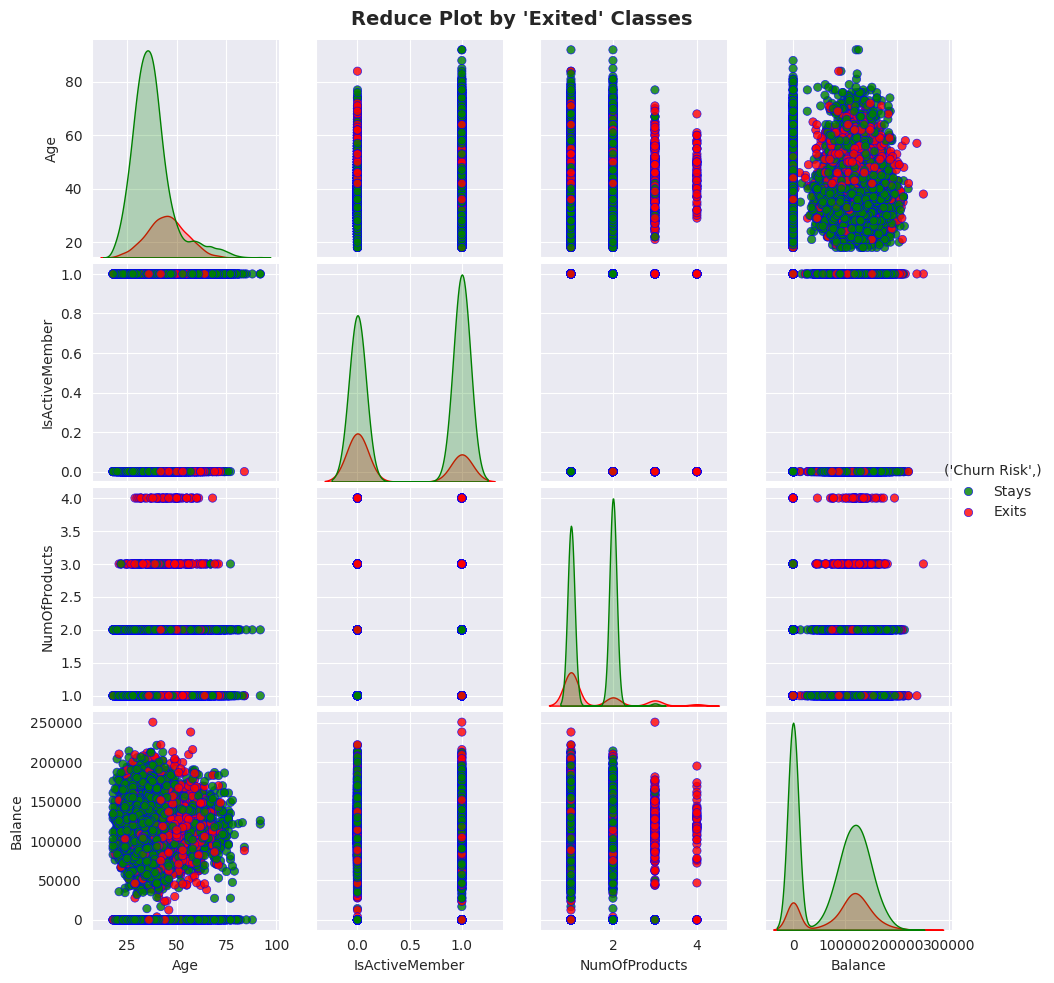

In [117]:
# Plot Seaborn's pairplot
g = sns.pairplot(df,hue ='Exited',
                 vars=['Age','IsActiveMember','NumOfProducts','Balance'], # reduce to less features
                 palette={0 : 'green',
                          1 : 'red'},
                 plot_kws={'alpha' : 0.8, 'edgecolor' : 'b', 'linewidth' : 0.5})

fig = g.fig
fig.subplots_adjust(top=0.95,wspace=0.2)
fig.suptitle("Reduce Plot by 'Exited' Classes",
             fontsize =14,
             fontweight='bold')

#Update the legend
new_title = 'Churn Risk',
g._legend.set_title(new_title)

#replace labels
for t, l in zip(g._legend.texts,new_labels) : t.set_text(l)

plt.show()

From density plots we can see that older customers and customer with more products more often leaving the bank.

## Violin Plots

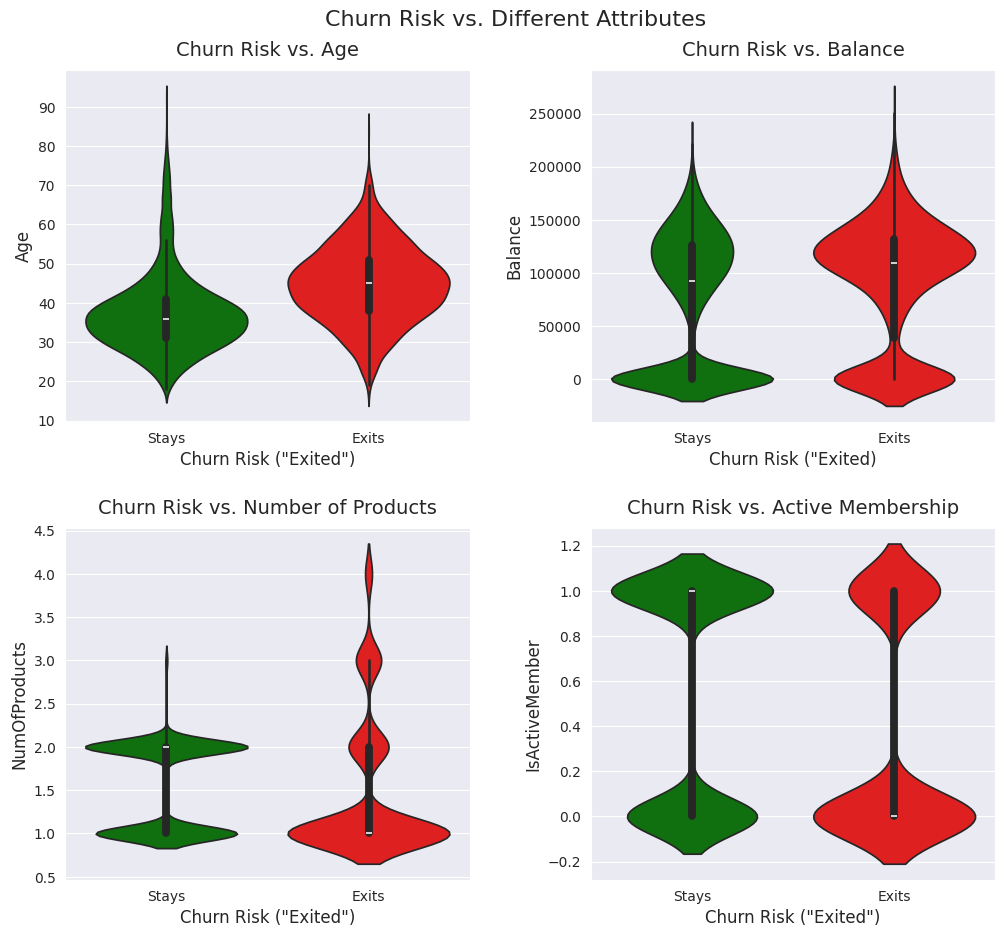

In [118]:
# Segment age by Exited and plot distributions
#  “categorical” variable Exited is a numeric
#  for plotting purposes only we will change it to real categorical variable

# Define palette
my_pal = {'Stays' : 'green', 'Exits': 'red'}
#Convert to categorial
hr = {0: 'Stays', 1: 'Exits'}
churn = df['Exited'].map(hr)

fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,10))
fig.suptitle('Churn Risk vs. Different Attributes', fontsize=16)
fig.subplots_adjust(top=0.92,wspace=0.3,hspace=0.3)

sns.violinplot(x=churn,
               y=df['Age'],
               order=['Stays','Exits'],
               palette=my_pal,
               ax=ax1)

ax1.set_title('Churn Risk vs. Age', fontsize=14, pad=10)
ax1.set_ylabel('Age',size=12)
ax1.set_xlabel('Churn Risk ("Exited")', size=12)

sns.violinplot(x=churn,
               y=df['Balance'],
               order=['Stays','Exits'],
               palette=my_pal,
               ax=ax2)

ax2.set_title('Churn Risk vs. Balance', fontsize=14, pad=10)
ax2.set_ylabel('Balance',size=12)
ax2.set_xlabel('Churn Risk ("Exited)',size=12)

sns.violinplot(x=churn,
               y=df['NumOfProducts'],
               order=['Stays','Exits'],
               palette=my_pal,
               ax=ax3)

ax3.set_title('Churn Risk vs. Number of Products',fontsize=14,pad=10)
ax3.set_ylabel('NumOfProducts',size=12)
ax3.set_xlabel('Churn Risk ("Exited")',size=12)

sns.violinplot(x=churn,
               y=df['IsActiveMember'],
               order=['Stays','Exits'],
               palette=my_pal,
               ax=ax4)

ax4.set_title('Churn Risk vs. Active Membership',fontsize=14,pad=10)
ax4.set_ylabel('IsActiveMember',size=12)
ax4.set_xlabel('Churn Risk ("Exited")',size=12)
plt.show()

Violin plots are confirming the earlier statement that older customers and customer with more products are more likely to leave the bank.

## Distributions of the Target Feature

In [119]:
# Define our target variable
y = df.Exited

In [120]:
y.shape

(10000,)

Let's define a small helper funtcion which displays count and percentage per class of the target feature.

In [121]:
# Function to display count and percentage per class of target feature
def class_count(a):
  counter=Counter(a)
  kv=[list(counter.keys()),list(counter.values())]
  dff = pd.DataFrame(np.array(kv).T,columns=['Exited','Count'])
  dff["Count"] = dff["Count"].astype('int64')
  dff['%'] = round(dff['Count'] / a.shape[0] * 100,2)
  return dff.sort_values('Count',ascending=False)

In [122]:
#Let's use the function
dfcc = class_count(y)
dfcc

,Exited,Count,%
1,0,7963,79.63
0,1,2037,20.37


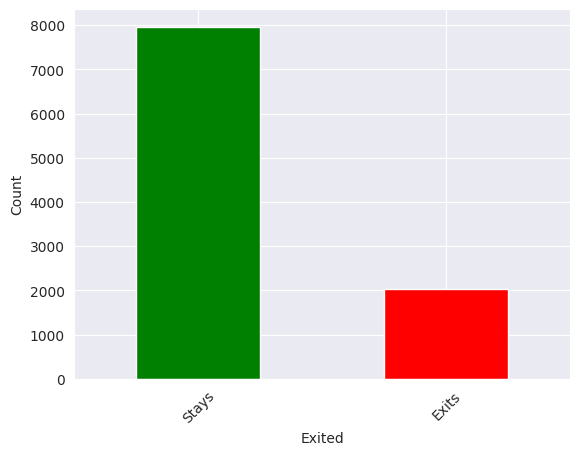

In [123]:
# Plot distribution of target variable, Exited column

labels=['Stays','Exits']
dfcc.plot.bar(x='Exited',y='Count',color=['g','r'],legend=False)
plt.xticks(dfcc['Exited'],labels,rotation=45)
plt.ylabel('Count')
plt.show()

We can see that our dataset is imbalanced. The majority class, "Stays" (0), has around 80% data points and the minority class, "Exits" (1), has around 20% datapoints.

To address this, in our machine learning algorithms we will use SMOTE (Synthetic Minority Over-sampling Technique).

### Finalizing the Dataframe

In [124]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Save the dataframe as the analytical base table

In [126]:
# Save analytics base table
#df.to_csv('analytics_base.csv',index=None)

## Bank Customer Churn Prediction - Summary

## Load Analytical Base Table

In [127]:
df = pd.read_csv(os.path.join("analytics_base.csv"))
print(f"DataFrame dimensions: {df.shape}")
df.head()

DataFrame dimensions: (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Separate dataframe into separate object

In [128]:
#object for target variable
y = df.Exited

#object for input features
X= df.drop(['Exited'],axis=1)

#display shapes of X and y
print(X.shape,y.shape)

(10000, 10) (10000,)


## Create a Train Test Split

In [129]:
random_state = 10

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=random_state,
    stratify=y
)

print(len(X_train), len(X_test), len(y_train), len(y_test))


7000 3000 7000 3000


In [130]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)


In [131]:
os.makedirs('models', exist_ok=True)


## Logistic Regression

In [132]:
lr_model = imbl_pipe(
    preprocessor,
    SMOTE(random_state=10),
    LogisticRegression(max_iter=1000)
)
lr_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('smote', SMOTE(random_state=10)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

## Decision Tree

In [133]:
dt_model = imbl_pipe(
    preprocessor,
    SMOTE(random_state=10),
    DecisionTreeClassifier(max_depth=5, random_state=10)
)
dt_model.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('smote', SMOTE(random_state=10)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=10))])

## Random Forest

In [134]:
rf_model = imbl_pipe(
    preprocessor,
    SMOTE(random_state=10),
    RandomForestClassifier(n_estimators=200,random_state=10)
)
rf_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('smote', SMOTE(random_state=10)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=200, random_state=10))])

## SVM

In [135]:
svm_model = imbl_pipe(
    preprocessor,
    SMOTE(random_state=10),
    SVC(probability=True)
)
svm_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('smote', SMOTE(random_state=10)),
                ('svc', SVC(probability=True))])

## XGBOOST

In [136]:
xgb_model = imbl_pipe(preprocessor,SMOTE(random_state=10),
  xgb.XGBClassifier(
      n_estimators=300,
      max_depth=6,
      learning_rate=0.05,
      eval_metric='logloss',
      random_state=10
  )
)
xgb_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('smote', SMOTE(random_state=10)),
                ('xg...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

## Load Saved Models

In [137]:
import os
os.makedirs('models', exist_ok=True)

In [138]:
joblib.dump(dt_model, 'models/nate_decision_tree.sav')
joblib.dump(lr_model, 'models/nate_logistic_regression.sav')
joblib.dump(rf_model, 'models/nate_random_forest.sav')
joblib.dump(svm_model, 'models/SVM_model.sav')
joblib.dump(xgb_model, 'models/XGBoost_model.sav')


['models/XGBoost_model.sav']

We are going to create the dictionary *models* with names of all models. We will be using it later for plotting and displaying results of the models.

In [139]:
os.listdir('models')


['nate_random_forest.sav',
 'nate_logistic_regression.sav',
 'SVM_model.sav',
 'nate_decision_tree.sav',
 'XGBoost_model.sav']

In [140]:
dt_model  = joblib.load('models/nate_decision_tree.sav')
lr_model  = joblib.load('models/nate_logistic_regression.sav')
rf_model  = joblib.load('models/nate_random_forest.sav')
svm_model = joblib.load('models/SVM_model.sav')
xgb_model = joblib.load('models/XGBoost_model.sav')

In [141]:
models = {
    "Decision Tree" : dt_model,
    "Logistic Regression" : lr_model,
    "Random Forest" : rf_model,
    "SVM" : svm_model,
    "XGBoost" : xgb_model
}

for name, model in models.items():
  y_pred = model.predict(X_test)
  print(f"\n{name}")
  print("Accuracy", accuracy_score(y_test, y_pred))
  print("Precision:", precision_score(y_test,y_pred))
  print("Recall:", recall_score(y_test,y_pred))
  print("F1 Score :", f1_score(y_test,y_pred))


Decision Tree
Accuracy 0.7696666666666667
Precision: 0.45789473684210524
Recall: 0.7119476268412439
F1 Score : 0.5573350416399744

Logistic Regression
Accuracy 0.707
Precision: 0.37706422018348623
Recall: 0.6726677577741408
F1 Score : 0.48324514991181655

Random Forest
Accuracy 0.8356666666666667
Precision: 0.594855305466238
Recall: 0.6055646481178396
F1 Score : 0.6001622060016221

SVM
Accuracy 0.7693333333333333
Precision: 0.4557377049180328
Recall: 0.6824877250409165
F1 Score : 0.546526867627785

XGBoost
Accuracy 0.85
Precision: 0.6409807355516638
Recall: 0.5990180032733224
F1 Score : 0.6192893401015228


In [153]:
fit_models = {
    'dt'  : dt_model,
    'lr'  : lr_model,
    'rf'  : rf_model,
    'svm' : svm_model,
    'xgb' : xgb_model
}


In [154]:
# Create models dictionary, it will be needed for ploting
models = {
    'dt' : 'Decision Tree',
    'dl': 'Deep Learning',
    'lr' : 'Logistic Regression',
    'rf' : 'Random Forest',
    'svm' : 'Support Vector Machine (SVM)',
    'xgb' : 'XGBoost'
}

'target_names' variable will be used later for printing evaluation results.

In [155]:
target_names = ['Stays','Exits']

Helper Functions

The function for creating the dataframe with evaluation metrics for each model.

input: loaded models dictionary

output: evaluation metrics dataframe

In [156]:
def evaluation(fit_models):
  lst = []
  for name, model in fit_models.items():
    pred = model.predict(X_test)
    lst.append([name,
                precision_score(y_test, pred, average='macro'),
                recall_score(y_test,pred,average='macro'),
                f1_score(y_test,pred,average='macro'),
                accuracy_score(y_test,pred)])

  eval_df = pd.DataFrame(lst, columns=['model', 'Precision', 'recall', 'f1_macro','accuracy'])
  eval_df.set_index('model',inplace = True)
  return eval_df

**The helper function for displaying confusion matrix and classification report.**

    input: loaded models dictionary, models dictionary and a dictionary key for one of the models

    output: confusion matrix dataframe and classification report

In [163]:
def class_rep_cm(fit_models,models,model_id):
  pred = fit_models[model_id].predict(X_test)

  print()
  print('\t', models[model_id])
  print('\t', '='*len(models[model_id]))

  # Confusion Matrix
  conf_df = pd.DataFrame(
      confusion_matrix(y_test, pred),
      columns=target_names,
      index=target_names
  )

  conf_df.index.name = 'True Labels'
  conf_df = conf_df.rename_axis('Predicted Labels', axis='columns')
  display(conf_df)

  print()
  print(classification_report(y_test, pred, target_names=target_names))


**The function for ploting one model's confusion matrix heatmaps without and with normalization.**

input: loaded models dictionary, models dictionary and dictionary key for one model, colormap for heatmaps

output: plot of two heatmaps

In [166]:
def plot_conf_mat_w_and_norm(fit_models, models, model_id, color):
    # Predict classes
    pred = fit_models[model_id].predict(X_test)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(models[model_id], fontsize=14)
    fig.subplots_adjust(top=0.85, wspace=0.3)

    # Confusion Matrix (Without Normalization)
    mat = confusion_matrix(y_test, pred)
    sns.heatmap(
        mat,
        annot=True,
        annot_kws={"fontsize": 14},
        fmt="d",
        cbar=True,
        square=True,
        cmap=color,
        ax=ax1
    )

    ax1.set_xticklabels(target_names)
    ax1.set_yticklabels(target_names, va="center")
    ax1.set_xlabel("Predicted Label", fontsize=12)
    ax1.set_ylabel("True Labels", fontsize=12)
    ax1.set_title("Confusion Matrix")

    # Normalized Confusion Matrix
    matn = mat / mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(
        matn,
        annot=True,
        annot_kws={"fontsize": 14},
        fmt=".2f",
        cbar=True,
        square=True,
        cmap=color,
        vmin=0,
        vmax=1,
        ax=ax2
    )

    ax2.set_xticklabels(target_names)
    ax2.set_yticklabels(target_names, va="center")
    ax2.set_xlabel("Predicted Label", fontsize=12)
    ax2.set_ylabel("True Labels", fontsize=12)
    ax2.set_title("Normalized Confusion Matrix")

    plt.show()


The helper function for ploting heatmaps for normalized confusion matrices for all models.

input: loaded models dictionary, models dictionary and colormap for heatmaps

output: plot of heatmaps for each model

In [159]:
def plot_norm_conf_matrices(fit_models, models, color):
  #prepare lists of coordinates for axes
  lt = [] # list for full subplots
  ltd = [] # list for empty subplots
  col = 2 #number of columns
  n_mod = len(fit_models) # number of fitted models

  # Number of rows
  row = - (n_mod // -col)

  #create lists of coordiantes for full and empty subplots
  for r in range(row):
    for c in range(col):
      if n_mod >= (r + 1) * (c + 1):
        lt.append([r, c])

  # create figure and suplots
  figs_y = row * 4 #y_size
  f, axs = plt.subplots(row,col, figsize=(10, figs_y))
  f.suptitle("Normalized Confusion Matrices", fontsize=14)
  f.subplots_adjust(top=0.94,wspace=0.94,hspace=0.2)

  # Reshape axes; needed in case of only 1 row
  axs = axs.reshape(row,-col)

  #Loop to delete N last empty subplots(if any)
  for n in range(len(ltd)):
    r = ltd[n][0]
    c = ltd[n][1]
    f.delaxes(ax=axs[r, c])

  #Loop to plot all full subplots
  i = 0
  # Loop for each fitted model
  for id, model in fit_models.items():
    pred = model.predict(X_test)
    name = models[id]
    r = lt[i][0]
    c = lt[i][1]
    i += 1

    mat = confusion_matrix(y_test,pred)
    # normalized confusion matrix
    matn = mat / mat.sum(axis=1)[:,np.newaxis]

    ax = ax[r, c]
    sns.heatmap(matn,
                annot=True,
                annot_kws=dict(fontsize=14),
                fmt=".2f",
                cbar=False,
                square=True,
                cmap=color,
                vmin = 0,
                vmax = 1,
                ax=ax)

    ax.set_xtickslabels(labels=target_names)
    ax.set_ytickslabels(labels=target_names,va='center')
    ax.set_title(name)
    ax.set_xlabels('Predicted Labels', size=12)
    ax.set_ylabels('True', size = 12)

  plt.show()

## Display evaluation metrics

In [160]:
# Display evaluation metrics
loaded_models = fit_models
evaluation(loaded_models)


,Precision,recall,f1_macro,accuracy
model,,,,
dt,0.686021,0.748188,0.700835,0.769667
lr,0.636176,0.694224,0.639389,0.707000
rf,0.746755,0.750041,0.748371,0.835667
svm,0.681346,0.737016,0.695928,0.769333
xgb,0.770058,0.756604,0.762945,0.850000


During cross-validation we were trying two scorers, f1_macro and accuracy, and then used a model that had better recal for true positive ("Exits").

### Display confusion matrix and classification report

In [164]:
# Display classification report and confusion matrix for all models

for model in fit_models.keys():
    class_rep_cm(fit_models, models, model)



	 Decision Tree


Predicted Labels,Stays,Exits
True Labels,,
Stays,1874,515
Exits,176,435



              precision    recall  f1-score   support

       Stays       0.91      0.78      0.84      2389
       Exits       0.46      0.71      0.56       611

    accuracy                           0.77      3000
   macro avg       0.69      0.75      0.70      3000
weighted avg       0.82      0.77      0.79      3000


	 Logistic Regression


Predicted Labels,Stays,Exits
True Labels,,
Stays,1710,679
Exits,200,411



              precision    recall  f1-score   support

       Stays       0.90      0.72      0.80      2389
       Exits       0.38      0.67      0.48       611

    accuracy                           0.71      3000
   macro avg       0.64      0.69      0.64      3000
weighted avg       0.79      0.71      0.73      3000


	 Random Forest


Predicted Labels,Stays,Exits
True Labels,,
Stays,2137,252
Exits,241,370



              precision    recall  f1-score   support

       Stays       0.90      0.89      0.90      2389
       Exits       0.59      0.61      0.60       611

    accuracy                           0.84      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.84      0.84      0.84      3000


	 Support Vector Machine (SVM)


Predicted Labels,Stays,Exits
True Labels,,
Stays,1891,498
Exits,194,417



              precision    recall  f1-score   support

       Stays       0.91      0.79      0.85      2389
       Exits       0.46      0.68      0.55       611

    accuracy                           0.77      3000
   macro avg       0.68      0.74      0.70      3000
weighted avg       0.82      0.77      0.78      3000


	 XGBoost


Predicted Labels,Stays,Exits
True Labels,,
Stays,2184,205
Exits,245,366



              precision    recall  f1-score   support

       Stays       0.90      0.91      0.91      2389
       Exits       0.64      0.60      0.62       611

    accuracy                           0.85      3000
   macro avg       0.77      0.76      0.76      3000
weighted avg       0.85      0.85      0.85      3000



### Plot normalized confusion matrix heatmaps for all loaded models

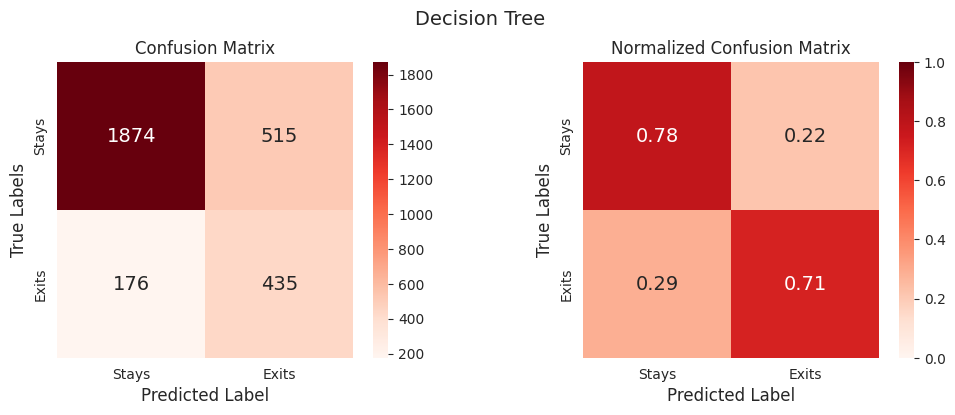

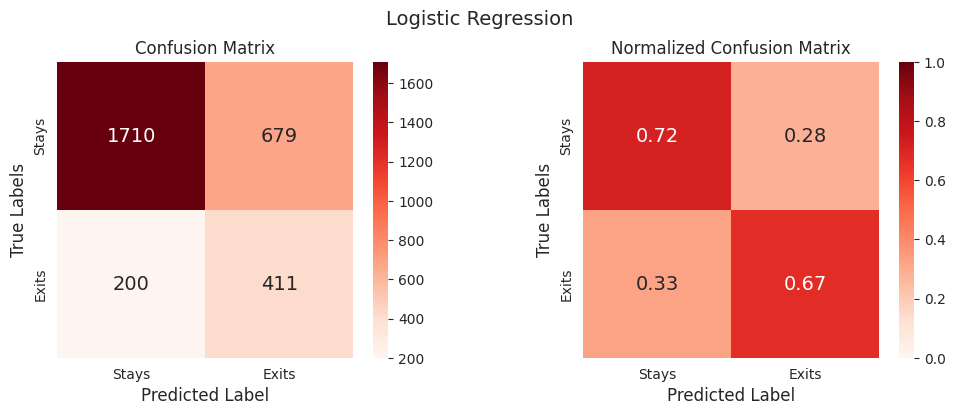

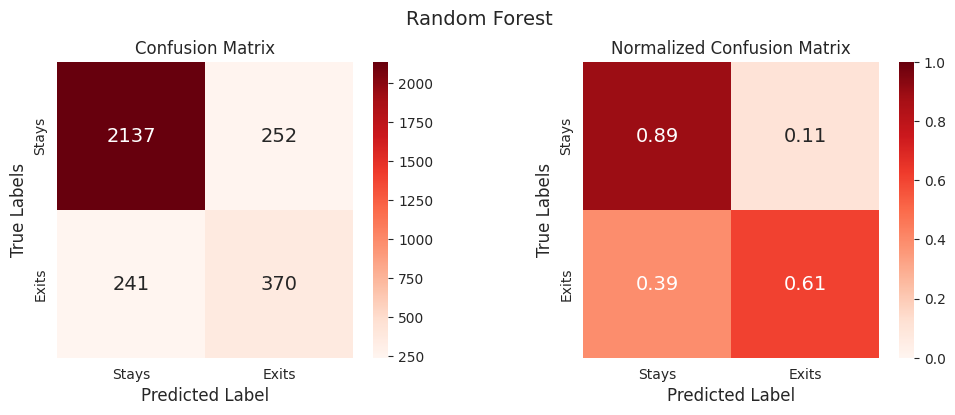

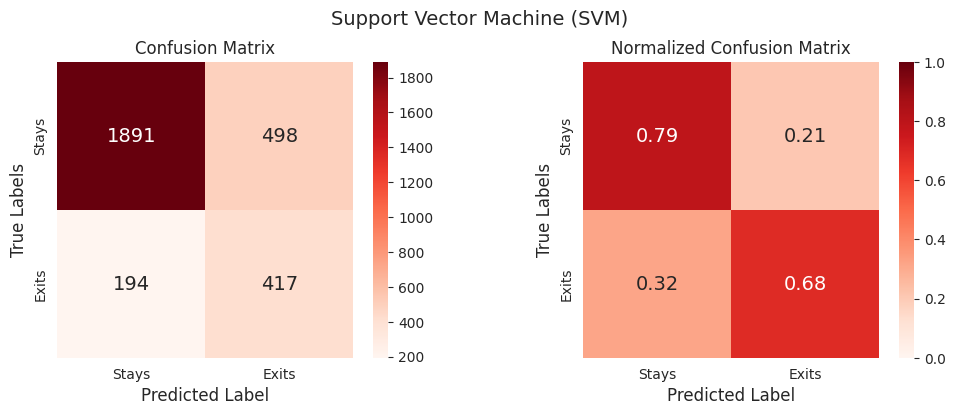

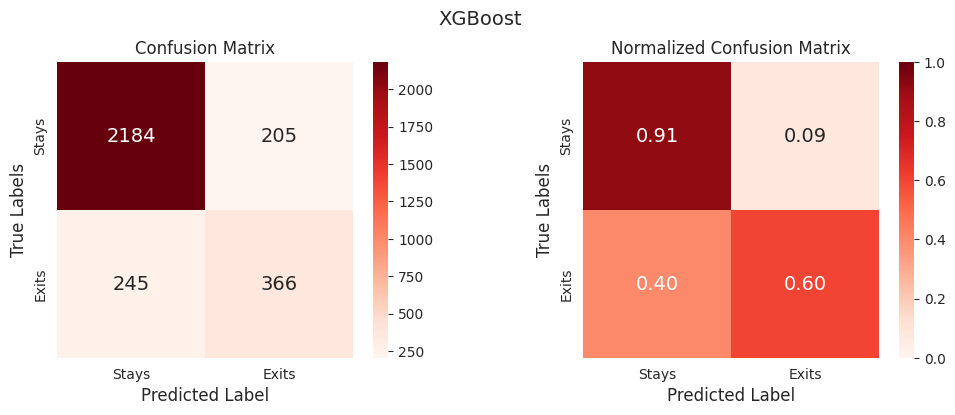

In [168]:
# Plot all confusion matrices
for model_id in fit_models.keys():
    plot_conf_mat_w_and_norm(fit_models, models, model_id, 'Reds')


From the above heatmaps we can see that Deep Learning and SVM are behaving the best. We have pretty leveled predictions for both, true negatives ("Stays") and true positives ("Exits").

### Impact of SMOTE to SVM model results

In our project we used of SMOTE to handle issues with the imbalanced data.

SMOTE (Synthetic Minority Over-sampling Technique) is an over-sampling method that creates new (synthetic) samples based on the samples in our minority classes. It finds the k-nearest-neighbors of each member of the minority classes.

The new samples should be generated only in the training set to ensure our model generalizes well to unseen data. We used imblearn python package.

We will now show what impact SMOTE had to results of our SVM model.